<h1> Structured data prediction using BigQuery ML </h1>

This notebook illustrates:
<ol>
<li> Training Machine Learning models using BQML
<li> Predicting with model
<li> Using spatial queries in BigQuery
<li> Building a linear regression model with feature crosses
</ol>

The goal is to predict taxifare given the starting and ending points.


## Set up notebook environment

In [ ]:
%pip install google-cloud-bigquery seaborn

Restart the kernel so that the new packages are picked up.

In [1]:
# change these to try this notebook out
PROJECT = 'cloud-training-demos'

In [2]:
import os
os.environ['PROJECT'] = PROJECT

In [3]:
%%bash
gcloud config set project $PROJECT

Updated property [core/project].


## Create BigQuery output dataset

If necessary, create a BigQuery dataset to store the trained model and artifacts of training.
(you can also do this from the GCP web console)

In [4]:
%%bash
#bq mk demos

In [9]:
from google.cloud import bigquery
bq = bigquery.Client(project=PROJECT)

## Create BigQuery training dataset

Please see [this notebook](https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/machine_learning/datasets/create_datasets.ipynb) for more context on this problem and how the features were chosen.

In [5]:
import seaborn as sns
import pandas as pd
import numpy as np
import shutil

In [36]:
def create_input_dataset(split, sample=1000):
  """
  split is TRAIN or EVAL
  sample=1000 pulls 1/1000 of full dataset
  """
  
  query="""
  WITH params AS (
    SELECT
    1 AS TRAIN,
    2 AS EVAL
    ),

  daynames AS
    (SELECT ['Sun', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat'] AS daysofweek),

  taxitrips AS (
  SELECT
    (tolls_amount + fare_amount) AS total_fare,
    daysofweek[ORDINAL(EXTRACT(DAYOFWEEK FROM pickup_datetime))] AS dayofweek,
    EXTRACT(HOUR FROM pickup_datetime) AS hourofday,
    pickup_longitude AS pickuplon,
    pickup_latitude AS pickuplat,
    dropoff_longitude AS dropofflon,
    dropoff_latitude AS dropofflat,
    passenger_count AS passengers
  FROM
    `nyc-tlc.yellow.trips`, daynames, params
  WHERE
    trip_distance > 0 AND fare_amount > 0 AND fare_amount < 100
    AND MOD(ABS(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING))),{0}) = params.{1}
  )

  SELECT *
  FROM taxitrips
  """.format(sample, split)
  
  return query

Note a few things about the query:
* The main part of the query is at the bottom: (SELECT * from taxitrips).
* taxitrips does the bulk of the extraction for the NYC dataset, with the SELECT containing my training features and label.
* The WHERE removes data that I don't want to train on.
* The WHERE also includes a sampling clause to pick up only 1/1000th of the data
* I define a variable called TRAIN so that I can quickly build an independent EVAL set.

In [15]:
query = create_input_dataset('TRAIN')
print(query)
trips = bq.query(query + " LIMIT 1000", project=PROJECT).to_dataframe()


  WITH params AS (
    SELECT
    1 AS TRAIN,
    2 AS EVAL
    ),

  daynames AS
    (SELECT ['Sun', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat'] AS daysofweek),

  taxitrips AS (
  SELECT
    (tolls_amount + fare_amount) AS total_fare,
    daysofweek[ORDINAL(EXTRACT(DAYOFWEEK FROM pickup_datetime))] AS dayofweek,
    EXTRACT(HOUR FROM pickup_datetime) AS hourofday,
    pickup_longitude AS pickuplon,
    pickup_latitude AS pickuplat,
    dropoff_longitude AS dropofflon,
    dropoff_latitude AS dropofflat,
    passenger_count AS passengers
  FROM
    `nyc-tlc.yellow.trips`, daynames, params
  WHERE
    trip_distance > 0 AND fare_amount > 0
    AND MOD(ABS(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING))),1000) = params.TRAIN
  )

  SELECT *
  FROM taxitrips
  


In [16]:
trips.head()

,total_fare,dayofweek,hourofday,pickuplon,pickuplat,dropofflon,dropofflat,passengers
0,2.5,Sun,12,-73.982177,40.770006,-73.981291,40.769298,1
1,2.5,Mon,15,-73.986812,40.759453,-73.986258,40.759607,2
2,3.0,Tues,6,-73.975887,40.757060,-73.973400,40.760550,5
3,3.5,Thurs,21,-73.954017,40.770487,-73.949420,40.772747,1
4,3.5,Sun,1,-73.989583,40.691210,-73.987220,40.692317,1


In [17]:
trips.describe()

,total_fare,hourofday,pickuplon,pickuplat,dropofflon,dropofflat,passengers
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000
mean,11.193580,13.615000,-72.422339,39.936178,-72.716949,40.059515,1.79800
std,9.624011,6.523598,10.612316,5.708082,9.567607,5.270821,1.38965
min,2.500000,0.000000,-74.044723,0.000000,-74.177602,0.000000,0.00000
25%,6.000000,9.000000,-73.991939,40.735623,-73.991719,40.734412,1.00000
50%,8.000000,14.000000,-73.980697,40.752287,-73.980773,40.753813,1.00000
75%,12.500000,19.000000,-73.967146,40.767698,-73.962595,40.768420,2.00000
max,69.650000,23.000000,0.000000,40.835693,0.000000,40.908057,6.00000


## Create ML model training query

This is the query to train the model

In [40]:
def create_train_query(dataset_query, model_name):
  query="""
CREATE or REPLACE MODEL {0}
OPTIONS
  (model_type='linear_reg', labels=['total_fare'], min_rel_progress=0.005, l2_reg=0.1) AS
  
  {1}
  
  """.format(model_name, dataset_query)
  return query

In [19]:
train_query = create_train_query( create_input_dataset('TRAIN'), 'demos.taxifare_model' )
print(train_query)


CREATE or REPLACE MODEL demos.taxifare_model
OPTIONS
  (model_type='linear_reg', labels=['total_fare'], min_rel_progress=0.005, ls_init_learn_rate=0.1) AS
  
  
  WITH params AS (
    SELECT
    1 AS TRAIN,
    2 AS EVAL
    ),

  daynames AS
    (SELECT ['Sun', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat'] AS daysofweek),

  taxitrips AS (
  SELECT
    (tolls_amount + fare_amount) AS total_fare,
    daysofweek[ORDINAL(EXTRACT(DAYOFWEEK FROM pickup_datetime))] AS dayofweek,
    EXTRACT(HOUR FROM pickup_datetime) AS hourofday,
    pickup_longitude AS pickuplon,
    pickup_latitude AS pickuplat,
    dropoff_longitude AS dropofflon,
    dropoff_latitude AS dropofflat,
    passenger_count AS passengers
  FROM
    `nyc-tlc.yellow.trips`, daynames, params
  WHERE
    trip_distance > 0 AND fare_amount > 0
    AND MOD(ABS(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING))),1000) = params.TRAIN
  )

  SELECT *
  FROM taxitrips
  
  
  


Note a few things about the above query:
* CREATE model is a safe way to ensure that you don't overwrite existing models. CREATE or REPLACE will … replace existing models.
* I specify my model type. Use linear_reg for regression problems and logistic_reg for classification problems.
* I specify that the total_fare column is the label.
* I ask that model training stop when the improvement is < 0.5%
* I specify the initial learning rate at 0.1 (this is optional, but shows you how to specify any optional parameters).

## Train the ML model

This will take <b>5-10 min</b>.  Wait for a message of the form "Job xyz completed".

In [20]:
bq.query(train_query, project=PROJECT).result()

Once the above job is complete, you can look at the training loss:

In [24]:
def show_training_loss(model_name):
  query = "SELECT iteration, loss from ML.TRAINING_INFO(MODEL {})".format(model_name)
  print(query)
  loss_df = bq.query(query, project=PROJECT).to_dataframe()
  loss_df['loss'] = np.sqrt(loss_df['loss'])  # mean square error to RMSE

  if len(loss_df) > 1:
    # Sometimes, BigQuery can compute a closed form solution.
    # See: https://medium.com/google-cloud/bigquery-ml-gets-faster-by-computing-a-closed-form-solution-sometimes-1baa5a838eb6
    loss_df.plot(x='iteration', y='loss');
  else:
    print(loss_df)
show_training_loss('demos.taxifare_model');

SELECT iteration, loss from ML.TRAINING_INFO(MODEL demos.taxifare_model)
   iteration      loss
0          0  9.463086


## Evaluate the model on an independent dataset

Let's look at overall RMSE (notice the use of ML.EVALUATE)

In [25]:
def create_eval_query(dataset_query, model_name):
  query="""
SELECT
  *,
  SQRT( mean_squared_error ) AS rmse
FROM
  ML.EVALUATE(MODEL {0},
  (
  {1}
  ))  
  """.format(model_name, dataset_query)
  return query
eval_query = create_eval_query( create_input_dataset('EVAL'), 'demos.taxifare_model' )
print(eval_query)


SELECT
  *,
  SQRT( mean_squared_error ) AS rmse
FROM
  ML.EVALUATE(MODEL demos.taxifare_model,
  (
  
  WITH params AS (
    SELECT
    1 AS TRAIN,
    2 AS EVAL
    ),

  daynames AS
    (SELECT ['Sun', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat'] AS daysofweek),

  taxitrips AS (
  SELECT
    (tolls_amount + fare_amount) AS total_fare,
    daysofweek[ORDINAL(EXTRACT(DAYOFWEEK FROM pickup_datetime))] AS dayofweek,
    EXTRACT(HOUR FROM pickup_datetime) AS hourofday,
    pickup_longitude AS pickuplon,
    pickup_latitude AS pickuplat,
    dropoff_longitude AS dropofflon,
    dropoff_latitude AS dropofflat,
    passenger_count AS passengers
  FROM
    `nyc-tlc.yellow.trips`, daynames, params
  WHERE
    trip_distance > 0 AND fare_amount > 0
    AND MOD(ABS(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING))),1000) = params.EVAL
  )

  SELECT *
  FROM taxitrips
  
  ))  
  


In [26]:
eval_df = bq.query(eval_query, project=PROJECT).to_dataframe()
eval_df

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance,rmse
0,5.927267,89.806649,0.323691,4.501331,0.000915,0.000917,9.476637


We can write a more sophisticated evaluation that computes the mean absolute percent error (MAPE) and group it by the taxifare to see how the errors vary with amount (notice the use of ML.PREDICT):

In [37]:
def create_faceted_eval_query(dataset_query, model_name):
  query="""
WITH predictions AS (
  SELECT
    total_fare,
    ABS(total_fare - predicted_total_fare)/total_fare AS error,
    ROUND(total_fare) AS dollars
  FROM
  ML.PREDICT(MODEL {0},
  (
  {1}
  )))

SELECT
  dollars,
  -- mean absolute percent error
  AVG(100 * error) AS MAPE
FROM predictions
GROUP BY dollars
ORDER BY
  dollars
  """.format(model_name, dataset_query)
  return query
eval_query = create_faceted_eval_query( create_input_dataset('EVAL'), 'demos.taxifare_model')
print(eval_query)


WITH predictions AS (
  SELECT
    total_fare,
    ABS(total_fare - predicted_total_fare)/total_fare AS error,
    ROUND(total_fare) AS dollars
  FROM
  ML.PREDICT(MODEL demos.taxifare_model,
  (
  
  WITH params AS (
    SELECT
    1 AS TRAIN,
    2 AS EVAL
    ),

  daynames AS
    (SELECT ['Sun', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat'] AS daysofweek),

  taxitrips AS (
  SELECT
    (tolls_amount + fare_amount) AS total_fare,
    daysofweek[ORDINAL(EXTRACT(DAYOFWEEK FROM pickup_datetime))] AS dayofweek,
    EXTRACT(HOUR FROM pickup_datetime) AS hourofday,
    pickup_longitude AS pickuplon,
    pickup_latitude AS pickuplat,
    dropoff_longitude AS dropofflon,
    dropoff_latitude AS dropofflat,
    passenger_count AS passengers
  FROM
    `nyc-tlc.yellow.trips`, daynames, params
  WHERE
    trip_distance > 0 AND fare_amount > 0 AND fare_amount < 100
    AND MOD(ABS(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING))),1000) = params.EVAL
  )

  SELECT *
  FROM taxitrips
  
  )))



(0, 100)

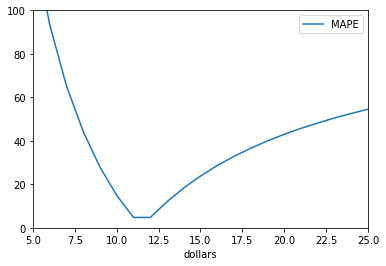

In [28]:
eval_df = bq.query(eval_query, project=PROJECT).to_dataframe()
ax = eval_df.plot(x='dollars', y='MAPE');
ax.set_xlim(5, 25)
ax.set_ylim(0,100)

Note that the error is quadratic -- it decreases and then increases with fare amount

## Feature engineering

Let's create some features that will improve our prediction result:
<ol>
<li> Compute distance between pickup and dropoff points as ST_Distance
<li> Do a feature cross of day-hour combination to learn traffic
<li> Do a feature cross of pickup-droff points to learn tolls
</ol>

In [41]:
def create_input_dataset_fc(split, sample=1000):
  """
  split is TRAIN or EVAL
  sample=1000 pulls 1/1000 of full dataset
  """
  
  query="""
WITH params AS (
  SELECT
  0.1 AS RES,
  1 AS TRAIN,
  2 AS EVAL
  ),

daynames AS
  (SELECT ['Sun', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat'] AS daysofweek),
  
taxitrips AS (
SELECT
  (tolls_amount + fare_amount) AS total_fare,
  daysofweek[ORDINAL(EXTRACT(DAYOFWEEK FROM pickup_datetime))] AS dayofweek,
  EXTRACT(HOUR FROM pickup_datetime) AS hourofday,
  ST_GeogPoint(pickup_longitude, pickup_latitude) AS pickup,
  ST_GeogPoint(dropoff_longitude, dropoff_latitude) AS dropoff,
  passenger_count AS passengers
FROM
  `nyc-tlc.yellow.trips`, daynames, params
WHERE
  trip_distance > 0 AND fare_amount > 0 AND fare_amount < 100
  and fare_amount >= 2.5 and pickup_longitude > -78 and pickup_longitude < -70 
      and dropoff_longitude > -78 and dropoff_longitude < -70 and pickup_latitude > 37 
      and pickup_latitude < 45 and dropoff_latitude > 37 and dropoff_latitude < 45 
      and passenger_count > 0
  AND MOD(ABS(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING))),{0}) = params.{1}
),

feateng AS (
  SELECT 
    total_fare,
    ST_Distance(pickup, dropoff) AS euclidean,
    CONCAT(dayofweek, CAST(hourofday AS STRING)) AS dayhr_fc,
    CONCAT(ST_AsText(ST_SnapToGrid(pickup, params.RES)),
           ST_AsText(ST_SnapToGrid(dropoff, params.RES))) AS loc_fc
  FROM
    taxitrips, params
)
  
  SELECT *
  FROM feateng
  """.format(sample, split)
  
  return query

Train:  this will take about <b> 5-10 minutes </b>

In [42]:
train_query = create_train_query( create_input_dataset_fc('TRAIN'), 'demos.taxifare_model_fc' )
print(train_query)
bq.query(train_query, project=PROJECT).result()


CREATE or REPLACE MODEL demos.taxifare_model_fc
OPTIONS
  (model_type='linear_reg', labels=['total_fare'], min_rel_progress=0.005, l2_reg=0.1) AS
  
  
WITH params AS (
  SELECT
  0.1 AS RES,
  1 AS TRAIN,
  2 AS EVAL
  ),

daynames AS
  (SELECT ['Sun', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat'] AS daysofweek),
  
taxitrips AS (
SELECT
  (tolls_amount + fare_amount) AS total_fare,
  daysofweek[ORDINAL(EXTRACT(DAYOFWEEK FROM pickup_datetime))] AS dayofweek,
  EXTRACT(HOUR FROM pickup_datetime) AS hourofday,
  ST_GeogPoint(pickup_longitude, pickup_latitude) AS pickup,
  ST_GeogPoint(dropoff_longitude, dropoff_latitude) AS dropoff,
  passenger_count AS passengers
FROM
  `nyc-tlc.yellow.trips`, daynames, params
WHERE
  trip_distance > 0 AND fare_amount > 0 AND fare_amount < 100
  and fare_amount >= 2.5 and pickup_longitude > -78 and pickup_longitude < -70 
      and dropoff_longitude > -78 and dropoff_longitude < -70 and pickup_latitude > 37 
      and pickup_latitude < 45 and dropoff_l

Evaluate the model once it is trained.

In [43]:
show_training_loss('demos.taxifare_model_fc')

SELECT iteration, loss from ML.TRAINING_INFO(MODEL demos.taxifare_model_fc)
   iteration      loss
0          0  3.895943


In [44]:
eval_query = create_eval_query( create_input_dataset_fc('EVAL'), 'demos.taxifare_model_fc' )
eval_df = bq.query(eval_query, project=PROJECT).to_dataframe()
eval_df

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance,rmse
0,2.229484,24.638316,0.066012,1.416893,0.714704,0.714706,4.9637


(0, 100)

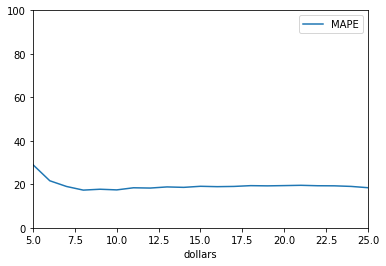

In [46]:
eval_query = create_faceted_eval_query( create_input_dataset_fc('EVAL'), 'demos.taxifare_model_fc')
eval_df = bq.query(eval_query, project=PROJECT).to_dataframe()
ax = eval_df.plot(x='dollars', y='MAPE');
ax.set_xlim(5, 25)
ax.set_ylim(0,100)

Notice that, with the feature crosses and spatial functions, we have gotten a lower RMSE and somewhat addressed the problem of errors increasing with fare amount.

## More data?

What if we train on more data? Note the sample=100 to use 10 million rows.  This will take <b> 10-15 min </b>

In [48]:
train_query = create_train_query( create_input_dataset_fc('TRAIN', sample=100), 'demos.taxifare_model_fc10' )
bq.query(train_query, project=PROJECT).result()

In [49]:
show_training_loss('demos.taxifare_model_fc10')

SELECT iteration, loss from ML.TRAINING_INFO(MODEL demos.taxifare_model_fc10)
   iteration      loss
0          0  3.907224


In [50]:
eval_query = create_eval_query( create_input_dataset_fc('EVAL'), 'demos.taxifare_model_fc10' )
eval_df = bq.query(eval_query, project=PROJECT).to_dataframe()
eval_df

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance,rmse
0,2.223445,23.050299,0.065663,1.415918,0.733092,0.733094,4.801073


It's better (\$4.80~ vs~ \$4.96, which is promising). We have to experiment with changing the resolution of the feature cross also -- because we have more data, it is possible that we could use more feature crosses

(0, 100)

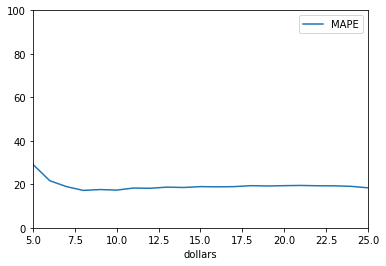

In [52]:
eval_query = create_faceted_eval_query( create_input_dataset_fc('EVAL'), 'demos.taxifare_model_fc10')
eval_df = bq.query(eval_query, project=PROJECT).to_dataframe()
ax = eval_df.plot(x='dollars', y='MAPE');
ax.set_xlim(5, 25)
ax.set_ylim(0,100)

## Geo visualization

Instead of grouping by the total amount, we can group by a spatial thing. Let's look at how the taxifare error varies depending on the dropoff point, by running the following query in the BigQuery Geo Viz:
<pre>
WITH predictions AS (
  SELECT
    ABS(total_fare - predicted_total_fare)/total_fare AS error,
    total_fare, pickup_gridpt, dropoff_gridpt
  FROM
  ML.PREDICT(MODEL demos.taxifare_model_fc,
  (
  
WITH params AS (
  SELECT
  0.1 AS RES,
  1 AS TRAIN,
  2 AS EVAL
  ),
daynames AS
  (SELECT ['Sun', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat'] AS daysofweek),
  
taxitrips AS (
SELECT
  (tolls_amount + fare_amount) AS total_fare,
  daysofweek[ORDINAL(EXTRACT(DAYOFWEEK FROM pickup_datetime))] AS dayofweek,
  EXTRACT(HOUR FROM pickup_datetime) AS hourofday,
  ST_GeogPoint(pickup_longitude, pickup_latitude) AS pickup,
  ST_GeogPoint(dropoff_longitude, dropoff_latitude) AS dropoff,
  passenger_count AS passengers
FROM
  `nyc-tlc.yellow.trips`, daynames, params
WHERE
  trip_distance > 0 AND fare_amount > 0 AND fare_amount < 100
  and fare_amount >= 2.5 and pickup_longitude > -78 and pickup_longitude < -70 
      and dropoff_longitude > -78 and dropoff_longitude < -70 and pickup_latitude > 37 
      and pickup_latitude < 45 and dropoff_latitude > 37 and dropoff_latitude < 45 
      and passenger_count > 0
  AND MOD(ABS(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING))),1000) = params.EVAL
),
feateng AS (
  SELECT 
    total_fare,
    ST_Distance(pickup, dropoff) AS euclidean,
    CONCAT(dayofweek, CAST(hourofday AS STRING)) AS dayhr_fc,
    CONCAT(ST_AsText(ST_SnapToGrid(pickup, params.RES)),
           ST_AsText(ST_SnapToGrid(dropoff, params.RES))) AS loc_fc,
    ST_AsText(ST_SnapToGrid(pickup, params.RES)) AS pickup_gridpt,
    ST_AsText(ST_SnapToGrid(dropoff, params.RES)) AS dropoff_gridpt
  FROM
    taxitrips, params
)
  
  SELECT *
  FROM feateng
  
  )))
SELECT
  dropoff_gridpt,
  COUNT(error) AS numpts,
  -- mean absolute percent error
  AVG(100 * error) AS MAPE
FROM predictions
GROUP BY dropoff_gridpt
HAVING numpts > 100
</pre>


Copyright 2018 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License

In [ ]:
%pip install google-cloud-bigquery seaborn